<a href="https://colab.research.google.com/github/furkanoruc/IntroDL/blob/main/Birds_Classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c csc4851-homework4

 99% 1.29G/1.30G [00:10<00:00, 132MB/s]
100% 1.30G/1.30G [00:10<00:00, 133MB/s]


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
! unzip csc4851-homework4.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_400/train/VERMILION FLYCATHER/102.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/103.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/104.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/105.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/106.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/107.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/108.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/109.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/110.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/111.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/112.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/113.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/114.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/115.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/116.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/117.jpg  
  inf

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import torch
import keras
import numpy as np
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Introducing an exploratory sample from the dataset to show birds names and classes

bird_classes = pd.read_csv('/content/birds_400/class_dict.csv')
bird_species = pd.read_csv('/content/birds_400/birds.csv')
bird_species.sample(10)

,class index,filepaths,labels,data set
38777,266,train/MIKADO PHEASANT/134.jpg,MIKADO PHEASANT,train
3814,25,train/ANNAS HUMMINGBIRD/050.jpg,ANNAS HUMMINGBIRD,train
23677,162,train/EMU/108.jpg,EMU,train
18845,130,train/CRESTED CARACARA/051.jpg,CRESTED CARACARA,train
17160,118,train/COMMON FIRECREST/046.jpg,COMMON FIRECREST,train
40373,278,train/NORTHERN PARULA/064.jpg,NORTHERN PARULA,train
36315,249,train/LARK BUNTING/066.jpg,LARK BUNTING,train
7844,53,train/BEARDED BARBET/034.jpg,BEARDED BARBET,train
37862,260,train/MALLARD DUCK/081.jpg,MALLARD DUCK,train
14437,99,train/CASPIAN TERN/144.jpg,CASPIAN TERN,train


In [ ]:
birdTypes = os.listdir('/content/birds_400/train')
len(birdTypes)

400

In [ ]:
species = np.array(bird_classes['class'])
#species

In [ ]:
def show_sample(df, num, species):
    df = df.sample(12)
    plt.figure(figsize=(20,20))
    for i in range(len(df)):
        #print(df.iloc[i]['filepaths'])
        path = '/content/birds_400/' + df.iloc[i]['filepaths']
        label = df.iloc[i]['labels']
        Type = df.iloc[i]['data set']
        plt.subplot(3, 4, i+1)
        img = tf.keras.preprocessing.image.load_img(path)
        plt.imshow(img)
        plt.xlabel(f'{label} : {Type}')
    plt.show()

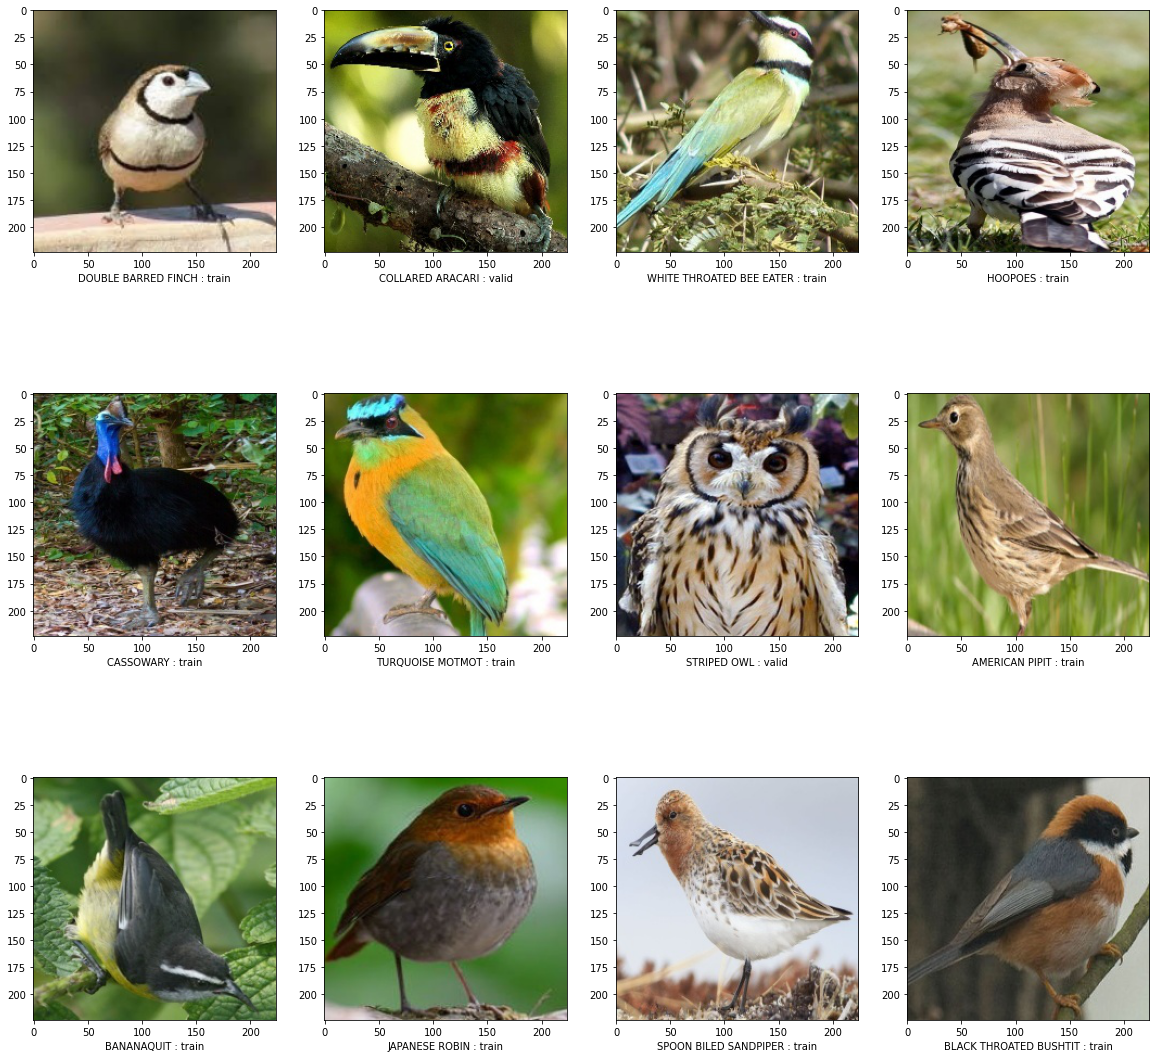

In [ ]:
show_sample(bird_species, 5, bird_species)


In [ ]:
train_data = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                rotation_range=20, horizontal_flip=True)
train_generator = train_data.flow_from_directory('/content/birds_400/train',
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

Found 58388 images belonging to 400 classes.


In [ ]:
valid_data = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                rotation_range=20, horizontal_flip=True)
validation_generator = valid_data.flow_from_directory('/content/birds_400/valid',
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

Found 2000 images belonging to 400 classes.


In [ ]:
test_data = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                rotation_range=20, horizontal_flip=True)
test_generator = test_data.flow_from_directory('/content/birds_400/test',
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

Found 2000 images belonging to 400 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3)


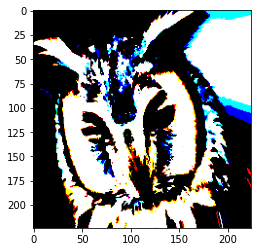

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3)


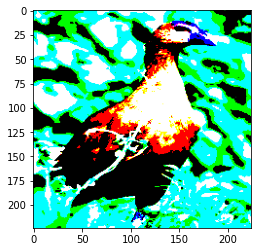

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3)


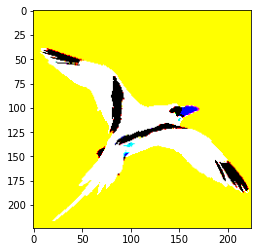

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3)


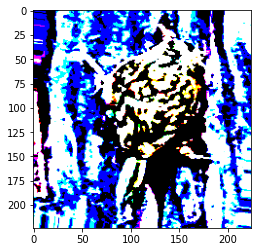

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3)


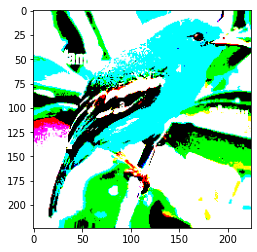

In [ ]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

In [ ]:
###

In [ ]:
#instantiate a base model with pre-trained weigts.
base_model=VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(400,activation='softmax',kernel_initializer='glorot_normal'))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 400)               8

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,epochs=10,validation_data=validation_generator,workers=10,use_multiprocessing=True)

Epoch 1/10
913/913 [==============================] - 766s 814ms/step - loss: 7.7036 - accuracy: 0.0271 - val_loss: 5.0576 - val_accuracy: 0.1360
Epoch 2/10
913/913 [==============================] - 717s 770ms/step - loss: 5.0440 - accuracy: 0.1329 - val_loss: 3.6460 - val_accuracy: 0.3215
Epoch 3/10
913/913 [==============================] - 712s 771ms/step - loss: 4.2395 - accuracy: 0.2372 - val_loss: 2.6092 - val_accuracy: 0.4560
Epoch 4/10
913/913 [==============================] - 723s 782ms/step - loss: 3.6482 - accuracy: 0.3179 - val_loss: 1.9813 - val_accuracy: 0.5680
Epoch 5/10
913/913 [==============================] - 713s 772ms/step - loss: 3.1972 - accuracy: 0.3810 - val_loss: 1.5458 - val_accuracy: 0.6370
Epoch 6/10
913/913 [==============================] - 710s 769ms/step - loss: 2.8438 - accuracy: 0.4366 - val_loss: 1.3024 - val_accuracy: 0.6960
Epoch 7/10
913/913 [==============================] - 719s 778ms/step - loss: 2.5466 - accuracy: 0.4871 - val_loss: 1.0575 -

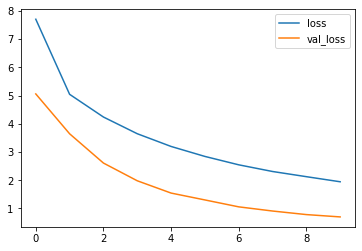

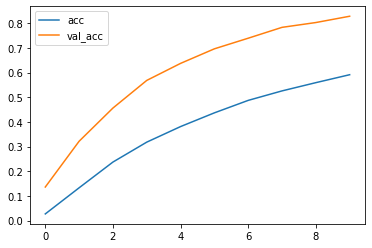

In [ ]:
#Some visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [ ]:
# Predict
predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=-1)

In [ ]:
predict2 = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predict2

array([[3.28508759e-06, 7.57849120e-05, 7.76420165e-06, ...,
        1.03975999e-05, 1.22441179e-06, 2.66020452e-05],
       [4.83987806e-03, 5.85087910e-05, 8.83559580e-04, ...,
        2.31585908e-03, 1.95539586e-04, 1.61319703e-03],
       [2.34228340e-19, 1.20073637e-14, 8.65284068e-14, ...,
        1.31424481e-16, 2.96185452e-16, 9.54534981e-16],
       ...,
       [1.56458546e-29, 3.01015497e-19, 3.31725063e-27, ...,
        3.88890011e-25, 1.17899954e-28, 1.49922851e-27],
       [4.76472025e-27, 1.40708431e-20, 1.70258824e-24, ...,
        1.21731761e-26, 2.94840675e-29, 7.30103587e-26],
       [1.42832665e-04, 5.84237705e-06, 3.94741626e-04, ...,
        1.01100696e-07, 9.39968245e-08, 2.28573981e-06]], dtype=float32)

In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

32/32 [==============================] - 27s 618ms/step - loss: 0.6150 - accuracy: 0.8390


[0.6150026321411133, 0.8389999866485596]

In [ ]:
predictions

array([[2.9994590e-20, 5.7592026e-19, 1.4822381e-18, ..., 3.5940359e-19,
        4.8235929e-18, 2.9899800e-18],
       [7.5761535e-22, 5.5104129e-20, 2.2607399e-24, ..., 6.5037403e-26,
        2.9676279e-26, 4.0462758e-22],
       [3.4921200e-18, 2.2702018e-16, 2.1706417e-13, ..., 1.3000532e-14,
        4.0511418e-07, 4.0548749e-13],
       ...,
       [6.0592217e-14, 2.7400986e-08, 1.5232041e-09, ..., 6.6365730e-15,
        3.9237345e-17, 4.8152769e-14],
       [1.2475606e-08, 5.1603854e-07, 4.8050668e-05, ..., 2.6013882e-09,
        5.4153719e-07, 8.1407983e-08],
       [1.0718004e-07, 2.6835483e-09, 4.6560790e-11, ..., 2.2339337e-08,
        3.8830109e-08, 1.2653091e-07]], dtype=float32)

In [ ]:
preds=model.predict_generator(generator=test_generator, verbose = 1)
preds=preds.round(decimals=2)

len(preds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


32/32 [==============================] - 30s 939ms/step


2000

In [ ]:
y_true = test_generator.classes
y_true

array([  0,   0,   0, ..., 399, 399, 399], dtype=int32)

In [ ]:
#loss = log_loss(np.ravel(y_ture), np.ravel(val_preds))

In [ ]:
log_loss_value = []

In [ ]:
for i in range(0,2000):
  true_label_holder = y_true[i]
  predicted_label = y_pred[i]
  prob_true_class = predictions[i, true_label_holder]
  if predicted_label == true_label_holder:
    #log_loss_value.append(-((y_true * np.log10(y_pred)) + (1-y_true) * np.log10(1-y_pred)).mean())
    log_loss_value.append(-((np.log10(prob_true_class))))
  elif prob_true_class != true_label_holder:
    log_loss_value.append(-((np.log10(1-prob_true_class))))





In [ ]:
len(log_loss_value)


2000

In [ ]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

summation_log_loss = zerolistmaker(400)

In [ ]:
k = 0
for i in range(0,2000,5):
  #print(i)
  for j in range(5):
    summation_log_loss[k] += log_loss_value[i+j]
  #print(summation_log_loss[k])
  print(k)
  k += 1 
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
loglosses_classes = zerolistmaker(400)

for i in range(len(summation_log_loss)):
   loglosses_classes[i] = summation_log_loss[i]/5

loglosses_classes

[3.953742612868566e-15,
 8.577802294035859e-07,
 0.00011066563976770765,
 1.137861762903262e-10,
 9.983201634121821e-06,
 4.3155671767274825e-09,
 2.5265116623896727e-05,
 5.2695295963555644e-06,
 1.172229879640003e-07,
 5.594153623241574e-10,
 9.398417754853685e-05,
 6.159918064962011e-09,
 1.4940158506731077e-05,
 0.0003356233478757009,
 5.041807794344955e-08,
 4.385377188599623e-06,
 1.0482281315299708e-07,
 9.450828898338811e-06,
 0.00015033382624589435,
 1.8101696656314652e-06,
 4.5685498559357533e-07,
 0.00010278622635848408,
 7.286222195662108e-10,
 6.249456040764636e-07,
 7.999140484521255e-07,
 1.0019976581271474e-07,
 6.462616685110958e-05,
 6.126348824636945e-05,
 8.626143755592756e-10,
 1.897558529309427e-05,
 4.1812231644724253e-07,
 0.0002738166688839531,
 1.7080222196552698e-07,
 2.7140978958957126e-05,
 6.291549033096012e-07,
 4.39637099293639e-05,
 0.0011197174859156295,
 7.385887872147103e-06,
 0.0001509448263347265,
 3.855865961498569e-05,
 0.0008729396520947179,
 5.

In [ ]:
df_submission = pd.DataFrame(loglosses_classes, columns=['birds'])
df_submission

,birds
0,3.953743e-15
1,8.577802e-07
2,1.106656e-04
3,1.137862e-10
4,9.983202e-06
...,...
395,1.390056e-06
396,7.359014e-07
397,1.638753e-06
398,1.589610e-05


In [ ]:
df_submission.to_csv('Furkan_Birds_Submission.csv', index=True)

In [56]:
pd.DataFrame(predictions).to_csv('prediction_matrix_birds.csv', index=True)